## Library Loading

In [65]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as st
from scipy import stats
from sklearn.model_selection import cross_val_score, KFold, RepeatedStratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.pipeline import Pipeline
from sklearn.utils import resample
from sklearn.svm import SVC
from skrvm import RVC


## Data Loading and Cleaning

In [66]:
data = pd.read_excel("PCA_Data.xlsx")
data['PSA'] = data['baselinePSA']

# Function to remove outliers
def remove_outliers(x):
    Q1 = np.percentile(x, 25)
    Q3 = np.percentile(x, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return np.where((x >= lower_bound) & (x <= upper_bound), x, np.nan)

# Remove outliers for each variable
for col in ['Exon9', 'Exon4a', 'Exon4b', 'PSA']:
    data[col] = remove_outliers(data[col])

# Drop rows with missing values
data = data.dropna(subset=['Exon9', 'Exon4a', 'PSA'])

data['Gleason'].replace('N/A', 0, inplace=True)

# Convert Gleason Risk to binary: 1 for High, 0 for Low
data['GleasonRiskBinary'] = data['GleasonRiskCode'].astype('category')

data['GleasonCodes'] = np.where(data['Gleason'] == 0, 0, 
                                 np.where(data['Gleason'] == 6, 1, 
                                          np.where(data['Gleason'] >= 7, 2, 0)))

/var/folders/jj/v8sb93px4t91q34p4v5rc6780000gn/T/ipykernel_1690/3444576033.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Gleason'].replace('N/A', 0, inplace=True)


In [67]:
dataMoAA = pd.read_excel("PCA_Data.xlsx")
dataMoAA['PSA'] = dataMoAA['baselinePSA']

dataMoAA = dataMoAA[dataMoAA['RACE'] == 'Black']

# Remove outliers for each variable
for col in ['Exon9', 'Exon4a', 'Exon4b', 'PSA']:
    dataMoAA[col] = remove_outliers(dataMoAA[col])

# Drop rows with missing values
dataMoAA = dataMoAA.dropna(subset=['Exon9', 'Exon4a', 'PSA'])

dataMoAA['Gleason'].replace('N/A', 0, inplace=True)

# Convert Gleason Risk to binary: 1 for High, 0 for Low
dataMoAA['GleasonRiskBinary'] = dataMoAA['GleasonRiskCode'].astype('category')

dataMoAA['GleasonCodes'] = np.where(dataMoAA['Gleason'] == 0, 0, 
                                 np.where(dataMoAA['Gleason'] == 6, 1, 
                                          np.where(dataMoAA['Gleason'] >= 7, 2, 0)))


/var/folders/jj/v8sb93px4t91q34p4v5rc6780000gn/T/ipykernel_1690/164002962.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dataMoAA['Gleason'].replace('N/A', 0, inplace=True)


## Correlation Matrix



 General Population


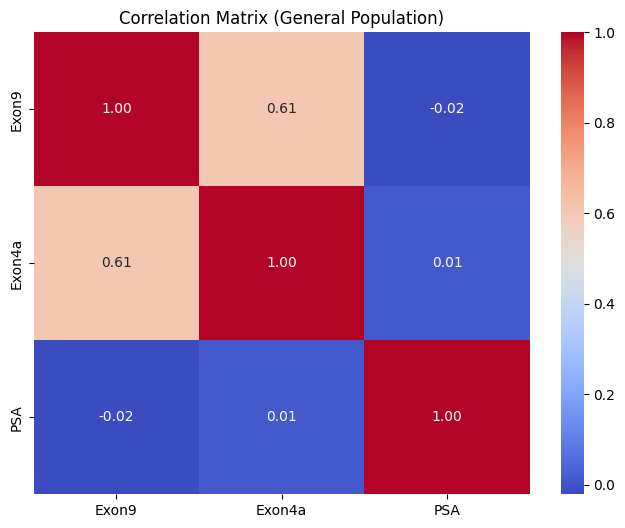



 MoAA Population


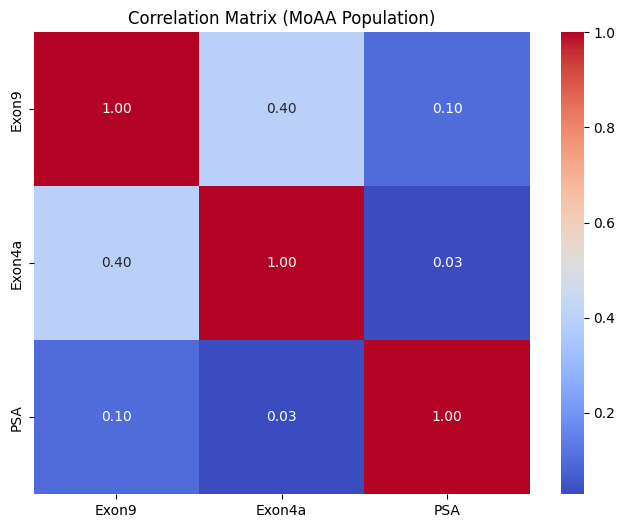

In [68]:
def plot_correlation_matrix(data, title):
    corr_matrix = data[['Exon9', 'Exon4a', 'PSA']].corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt='.2f')
    plt.title(title)
    plt.show()

# Plot correlation matrices for both datasets
print("\n\n General Population")
plot_correlation_matrix(data, 'Correlation Matrix (General Population)')

print("\n\n MoAA Population")
plot_correlation_matrix(dataMoAA, 'Correlation Matrix (MoAA Population)')

# Prostate cancer Prediction 
# Risk as the Response Variable

## Data Visualization: Distribution

General Population


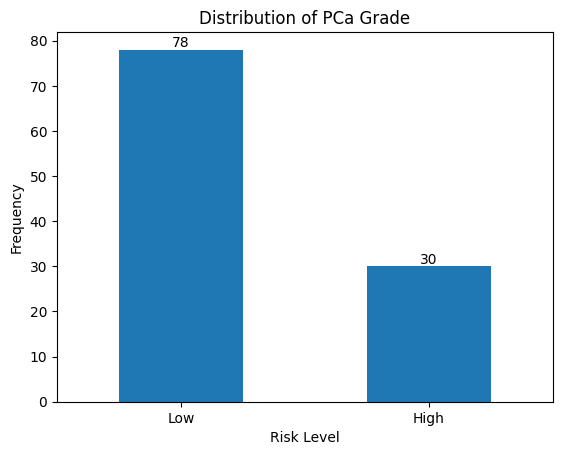



 MoAA Population


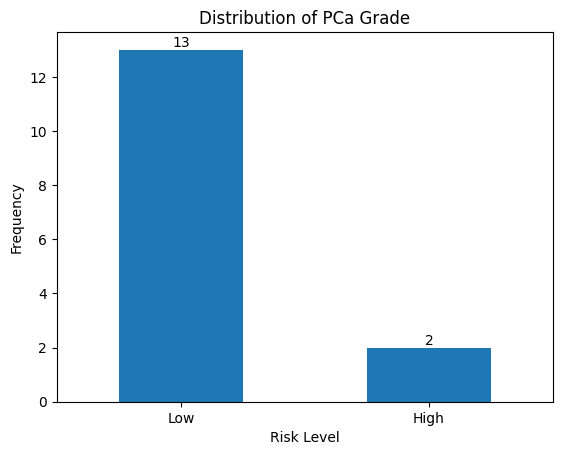

In [69]:
def plot_risk_distribution(data, title):
    counts = data['Gleason Risk'].value_counts()
    counts.plot(kind='bar')
    plt.title(title)
    plt.xlabel('Risk Level')
    plt.ylabel('Frequency')
    plt.xticks(rotation=0)  # Keep labels horizontal for better readability

    # Add numbers on top of the bars
    for index, value in enumerate(counts):
        plt.text(index, value, str(value), ha='center', va='bottom', fontsize=10)

    plt.show()

# Plot distributions for both datasets
print("General Population")
plot_risk_distribution(data, 'Distribution of PCa Grade')

print("\n\n MoAA Population")
plot_risk_distribution(dataMoAA, 'Distribution of PCa Grade')




## Data Visualization: Boxplots

General Population


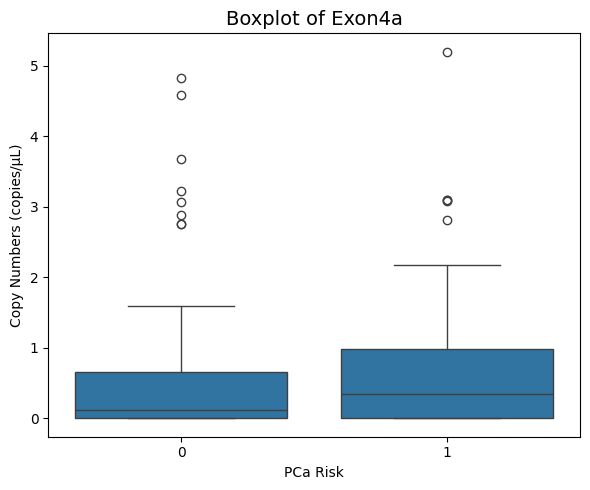

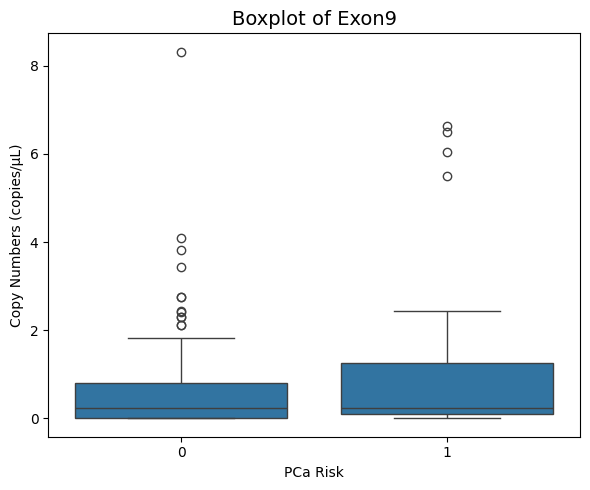

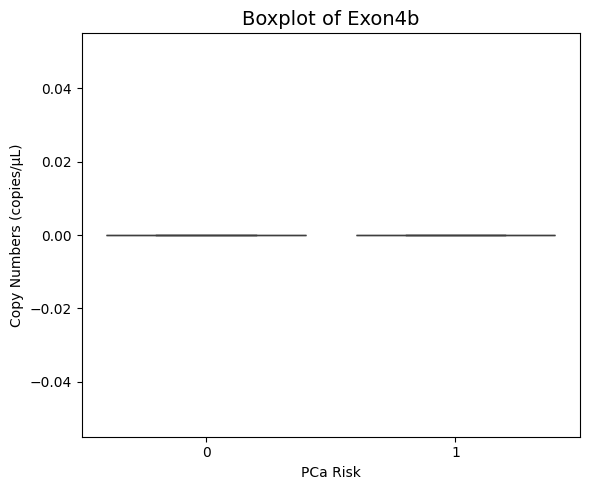



 MoAA Population


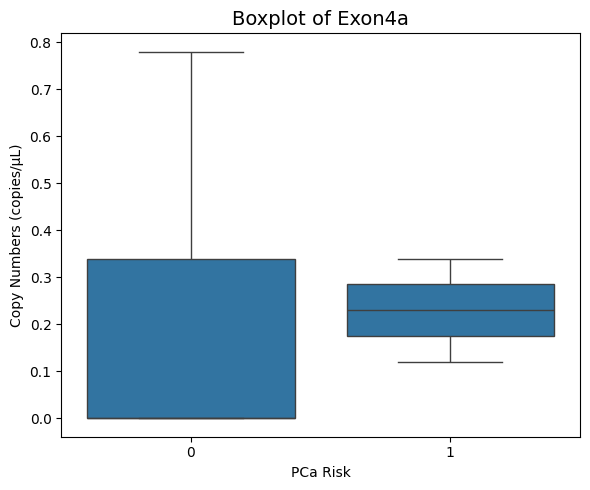

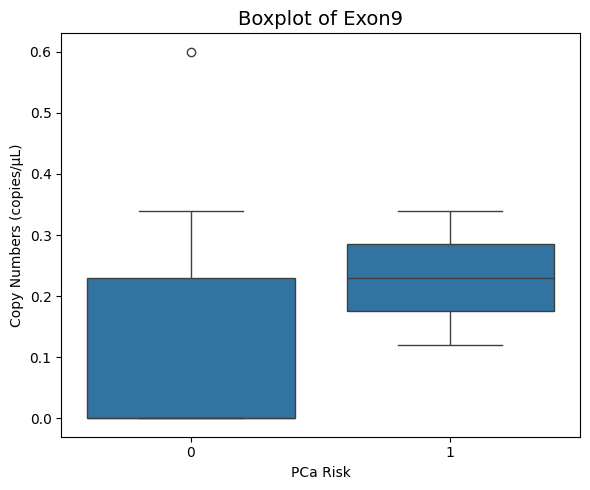

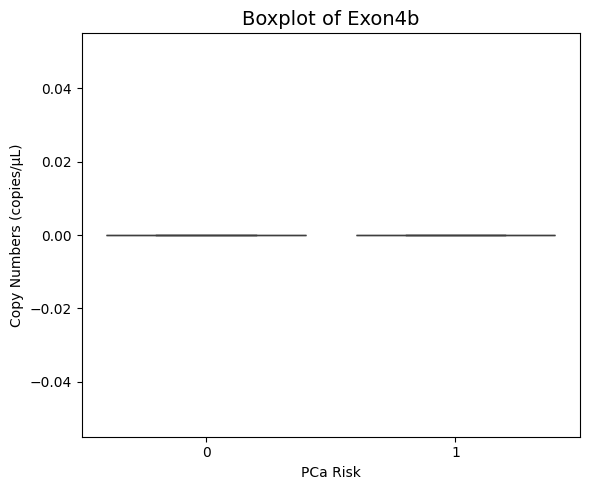

In [70]:
# Define the features
features = ['Exon4a', 'Exon9', 'Exon4b']

# Function to plot boxplots for given data
def plot_boxplots(data):
    for feature in features:
        plt.figure(figsize=(6, 5))

        # Plot boxplot for the current feature
        sns.boxplot(x='GleasonRiskBinary', y=feature, data=data)
        
        # Customize the title and axis labels
        plt.title(f"Boxplot of {feature}", fontsize=14)
        plt.xlabel("PCa Risk")
        plt.ylabel("Copy Numbers (copies/µL)")
        
        # Display the plot
        plt.tight_layout()
        plt.show()

# Plot for both datasets
print("General Population")
plot_boxplots(data)

print("\n\n MoAA Population")
plot_boxplots(dataMoAA)

General Population


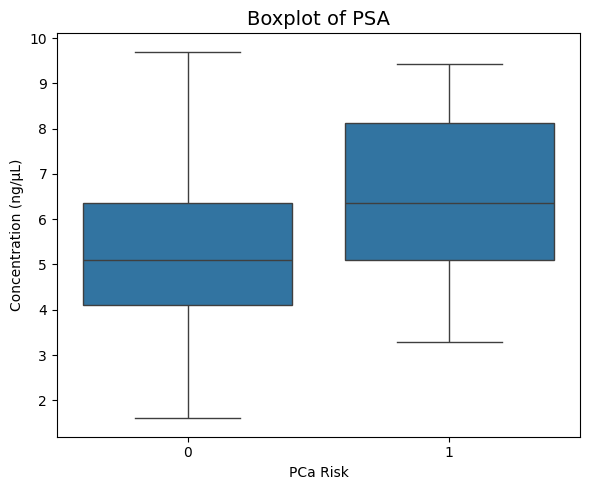



 MoAA Population


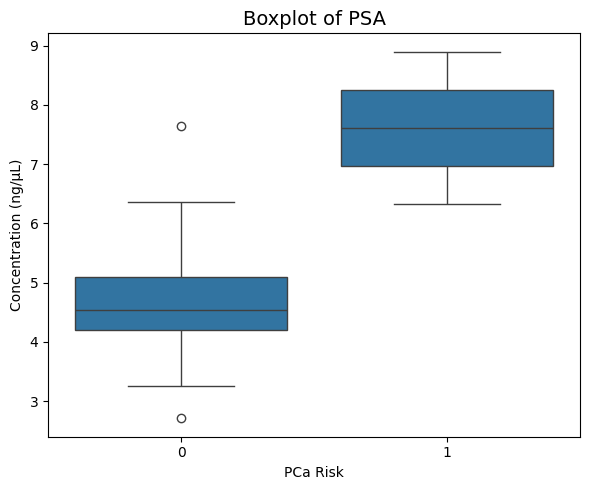

In [71]:
# Function to plot boxplot for baseline PSA
def plot_baseline_psa_boxplot(data):
    plt.figure(figsize=(6, 5))
    
    # Plot boxplot for baseline PSA
    sns.boxplot(x='GleasonRiskBinary', y='PSA', data=data)
    
    # Customize the title and axis labels
    plt.title(f"Boxplot of PSA", fontsize=14)
    plt.xlabel("PCa Risk")
    plt.ylabel("Concentration (ng/µL)")
    
    # Display the plot
    plt.tight_layout()
    plt.show()

# Plot for both datasets
print("General Population")
plot_baseline_psa_boxplot(data)

print("\n\n MoAA Population")
plot_baseline_psa_boxplot(dataMoAA)


## Significance Test (T-test)

In [72]:
# Define models
models = [
    ['PSA'],
    ['Exon4a'],            
    ['Exon9'],
    ['PSA', 'Exon4a'],            
    ['PSA', 'Exon9'], 
    ['PSA', 'Exon4a', 'Exon9']            
]

# Function to perform t-tests for a dataset
def perform_t_tests(data, dataset_name):
    for model in models:
        print(f"\nModel: {', '.join(model)} (Dataset: {dataset_name})")
        
        X = data[model]
        y = data['GleasonRiskBinary']

        # Split data into two groups based on the binary outcome
        group1 = X[y == 0].mean(axis=1)  # Group where GleasonRiskBinary is 0
        group2 = X[y == 1].mean(axis=1)  # Group where GleasonRiskBinary is 1

        # Perform t-test
        t_stat, p_value = stats.ttest_ind(group1, group2, equal_var=False)  # Welch's t-test

        # Print results
        print(f"T-statistic: {t_stat:.3f}")
        print(f"P-value: {p_value:.3f}")

        # Interpret the p-value
        alpha = 0.05
        if p_value < alpha:
            print("Reject the null hypothesis: significant difference between groups.")
        else:
            print("Fail to reject the null hypothesis: no significant difference between groups.")

# Perform t-tests for both datasets
print("General Population")
perform_t_tests(data, 'General Population')

print("\n\nMoAA Population")
perform_t_tests(dataMoAA, 'MoAA Population')

General Population

Model: PSA (Dataset: General Population)
T-statistic: -3.224
P-value: 0.002
Reject the null hypothesis: significant difference between groups.

Model: Exon4a (Dataset: General Population)
T-statistic: -1.131
P-value: 0.264
Fail to reject the null hypothesis: no significant difference between groups.

Model: Exon9 (Dataset: General Population)
T-statistic: -1.270
P-value: 0.212
Fail to reject the null hypothesis: no significant difference between groups.

Model: PSA, Exon4a (Dataset: General Population)
T-statistic: -3.552
P-value: 0.001
Reject the null hypothesis: significant difference between groups.

Model: PSA, Exon9 (Dataset: General Population)
T-statistic: -3.429
P-value: 0.001
Reject the null hypothesis: significant difference between groups.

Model: PSA, Exon4a, Exon9 (Dataset: General Population)
T-statistic: -3.105
P-value: 0.003
Reject the null hypothesis: significant difference between groups.


MoAA Population

Model: PSA (Dataset: MoAA Population)
T-s

## Likelihood Ratio Test

In [73]:

# Custom function for chi-square probability
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

# Define function to perform likelihood ratio test
def likelihood_ratio_test(llmin, llmax):
    lr_stat = 2 * (llmax - llmin)
    p_value = stats.chisqprob(lr_stat, 1)  # llmax has 1 dof more than llmin
    return lr_stat, p_value  # Results of likelihood ratio test

# Define model pairs for comparison
model_pairs = [
    (['PSA', 'Exon4a', 'Exon9'], ['PSA', 'Exon4a']),
    (['PSA', 'Exon4a', 'Exon9'], ['PSA', 'Exon9']),
    (['PSA', 'Exon4a', 'Exon9'], ['PSA']),
    (['PSA', 'Exon4a'], ['PSA']),
    (['PSA', 'Exon9'], ['PSA'])
]


# Function to perform likelihood ratio tests for a given dataset
def perform_likelihood_ratio_tests(data, dataset_name):
    y = data['GleasonRiskBinary']
    
    # Loop through each model pair
    for full_features, reduced_features in model_pairs:
        print(f"\nTesting model: {full_features} vs {reduced_features} (Dataset: {dataset_name})")

        # Fit the full model
        X_full = data[full_features]
        X_full = sm.add_constant(X_full)  # Adding intercept
        full_model = sm.Logit(y, X_full).fit(disp=0)  # disp=0 to suppress output

        # Fit the reduced model
        X_reduced = data[reduced_features]
        X_reduced = sm.add_constant(X_reduced)  # Adding intercept
        reduced_model = sm.Logit(y, X_reduced).fit(disp=0)  # disp=0 to suppress output

        # Get log-likelihood values
        llmax = full_model.llf  # Log-likelihood of the full model
        llmin = reduced_model.llf  # Log-likelihood of the reduced model

        # Perform the likelihood ratio test
        lr_stat, p_value = likelihood_ratio_test(llmin, llmax)

        # Print results
        print(f"Likelihood Ratio Statistic: {lr_stat:.4f}")
        print(f"P-value: {p_value:.4f}")

# Perform likelihood ratio tests for both datasets
print("General Population")
perform_likelihood_ratio_tests(data, 'General Population')

print("\n\n\nMoAA Population")
perform_likelihood_ratio_tests(dataMoAA, 'MoAA Population')

General Population

Testing model: ['PSA', 'Exon4a', 'Exon9'] vs ['PSA', 'Exon4a'] (Dataset: General Population)
Likelihood Ratio Statistic: 1.1686
P-value: 0.2797

Testing model: ['PSA', 'Exon4a', 'Exon9'] vs ['PSA', 'Exon9'] (Dataset: General Population)
Likelihood Ratio Statistic: 0.1593
P-value: 0.6898

Testing model: ['PSA', 'Exon4a', 'Exon9'] vs ['PSA'] (Dataset: General Population)
Likelihood Ratio Statistic: 2.8358
P-value: 0.0922

Testing model: ['PSA', 'Exon4a'] vs ['PSA'] (Dataset: General Population)
Likelihood Ratio Statistic: 1.6672
P-value: 0.1966

Testing model: ['PSA', 'Exon9'] vs ['PSA'] (Dataset: General Population)
Likelihood Ratio Statistic: 2.6765
P-value: 0.1018



MoAA Population

Testing model: ['PSA', 'Exon4a', 'Exon9'] vs ['PSA', 'Exon4a'] (Dataset: MoAA Population)
Likelihood Ratio Statistic: 0.2710
P-value: 0.6027

Testing model: ['PSA', 'Exon4a', 'Exon9'] vs ['PSA', 'Exon9'] (Dataset: MoAA Population)
Likelihood Ratio Statistic: 0.0342
P-value: 0.8532

Tes

## Multiple Logisic Regression

### Train-Test Split 


### Youden's index threshold

In [74]:
# Function to evaluate models
def evaluate_models_mlr(data, dataset_name, train_size):
    for model in models:
        print(f"\nMetrics for model: {model} (Dataset: {dataset_name})")
        
        X = data[model]
        y = data['GleasonRiskBinary']

        # Split data with specified train size
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, random_state=66)

        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('logistic_regression', LogisticRegression())
        ])

        # Fit model
        pipeline.fit(X_train, y_train)

        # Get predicted probabilities
        y_pred_proba = pipeline.predict_proba(X_test)[:, 1]  # Probabilities for test set

        # Define thresholds
        thresholds = np.arange(0.0, 1.0, 0.1)
        best_youden_index = -1
        best_threshold = 0.5

        for threshold in thresholds:
            # Convert probabilities to binary predictions
            y_pred = (y_pred_proba >= threshold).astype(int)

            # Calculate confusion matrix
            conf_matrix = confusion_matrix(y_test, y_pred)

            # Check if the confusion matrix is valid for binary classification
            if conf_matrix.shape == (2, 2):
                tn, fp, fn, tp = conf_matrix.ravel()

                # Calculate sensitivity and specificity
                sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
                specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

                # Calculate PPV and NPV
                ppv = tp / (tp + fp) if (tp + fp) > 0 else 0
                npv = tn / (tn + fn) if (tn + fn) > 0 else 0

                # Calculate Youden's Index
                youden_index = sensitivity + specificity - 1

                # Check if this is the best threshold
                if youden_index > best_youden_index:
                    best_youden_index = youden_index
                    best_threshold = threshold

        # Apply the best threshold for final predictions
        y_pred_final = (y_pred_proba >= best_threshold).astype(int)

        # Calculate final metrics using the best threshold
        accuracy_test = metrics.accuracy_score(y_test, y_pred_final)
        recall_test = metrics.recall_score(y_test, y_pred_final)
        conf_matrix_test = confusion_matrix(y_test, y_pred_final)

        # Check the shape of the final confusion matrix before unpacking
        if conf_matrix_test.shape == (2, 2):
            tn_test, fp_test, fn_test, tp_test = conf_matrix_test.ravel()
            specificity_test = tn_test / (tn_test + fp_test)

            # Calculate final PPV and NPV
            final_ppv = tp_test / (tp_test + fp_test) if (tp_test + fp_test) > 0 else 0
            final_npv = tn_test / (tn_test + fn_test) if (tn_test + fn_test) > 0 else 0
            
            # Print metrics for test set
            print("\nTest Set Metrics:")
            print(f"Best Threshold: {best_threshold:.2f}")
            print(f"Accuracy: {accuracy_test:.3f}")
            print(f"Recall (Sensitivity): {recall_test:.3f}")
            print(f"Specificity: {specificity_test:.3f}")
            print(f"Positive Predictive Value (PPV): {final_ppv:.3f}")
            print(f"Negative Predictive Value (NPV): {final_npv:.3f}")
        else:
            print("\nTest Set Metrics:")
            print(f"Best Threshold: {best_threshold:.2f}")
            print(f"Accuracy: {accuracy_test:.3f}")
            print(f"Recall (Sensitivity): {recall_test:.3f}")
            print("Specificity: Not applicable (only one class present in predictions)")
            print("Positive Predictive Value (PPV): Not applicable")
            print("Negative Predictive Value (NPV): Not applicable")

# Evaluate models for both datasets with specified train sizes
print("General Population")
evaluate_models_mlr(data, 'General Population', train_size=0.6)

print("\n\n\nMoAA Population")
evaluate_models_mlr(dataMoAA, 'MoAA Population', train_size=0.6)

General Population

Metrics for model: ['PSA'] (Dataset: General Population)

Test Set Metrics:
Best Threshold: 0.30
Accuracy: 0.705
Recall (Sensitivity): 0.615
Specificity: 0.742
Positive Predictive Value (PPV): 0.500
Negative Predictive Value (NPV): 0.821

Metrics for model: ['Exon4a'] (Dataset: General Population)

Test Set Metrics:
Best Threshold: 0.30
Accuracy: 0.682
Recall (Sensitivity): 0.231
Specificity: 0.871
Positive Predictive Value (PPV): 0.429
Negative Predictive Value (NPV): 0.730

Metrics for model: ['Exon9'] (Dataset: General Population)

Test Set Metrics:
Best Threshold: 0.30
Accuracy: 0.727
Recall (Sensitivity): 0.154
Specificity: 0.968
Positive Predictive Value (PPV): 0.667
Negative Predictive Value (NPV): 0.732

Metrics for model: ['PSA', 'Exon4a'] (Dataset: General Population)

Test Set Metrics:
Best Threshold: 0.30
Accuracy: 0.750
Recall (Sensitivity): 0.538
Specificity: 0.839
Positive Predictive Value (PPV): 0.583
Negative Predictive Value (NPV): 0.812

Metrics f

###  K fold Cross validation and ROC 

General Population

Metrics for feature set: ['PSA'] (Dataset: General Population)

Metrics for feature set: ['Exon4a'] (Dataset: General Population)

Metrics for feature set: ['Exon9'] (Dataset: General Population)

Metrics for feature set: ['PSA', 'Exon4a'] (Dataset: General Population)

Metrics for feature set: ['PSA', 'Exon9'] (Dataset: General Population)

Metrics for feature set: ['PSA', 'Exon4a', 'Exon9'] (Dataset: General Population)


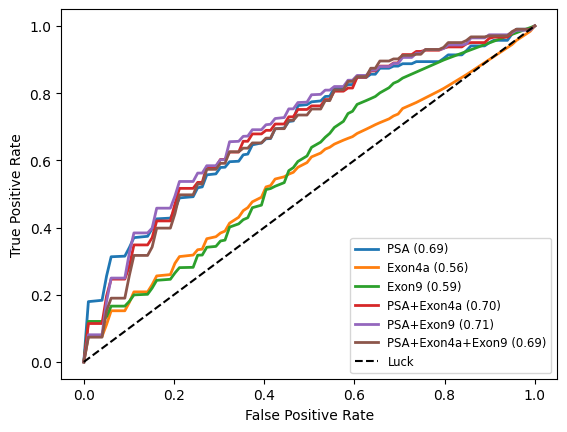




MoAA Population

Metrics for feature set: ['PSA'] (Dataset: MoAA Population)

Metrics for feature set: ['Exon4a'] (Dataset: MoAA Population)

Metrics for feature set: ['Exon9'] (Dataset: MoAA Population)

Metrics for feature set: ['PSA', 'Exon4a'] (Dataset: MoAA Population)

Metrics for feature set: ['PSA', 'Exon9'] (Dataset: MoAA Population)

Metrics for feature set: ['PSA', 'Exon4a', 'Exon9'] (Dataset: MoAA Population)


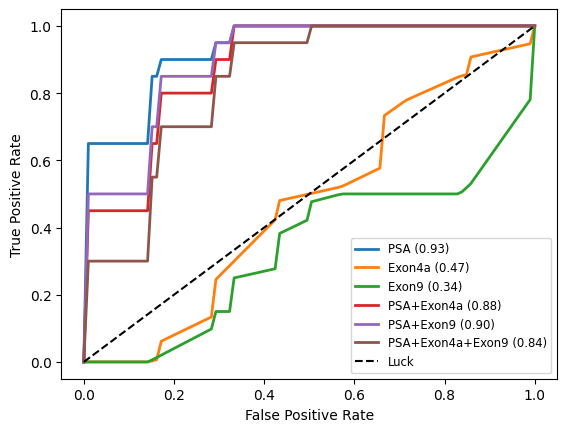

In [75]:
def evaluate_cross_validation(data, dataset_name, nsplits):
    # Loop through each model and perform 4-fold cross-validation with 10 repetitions
    nrepeats = 10
    score_list = []

    for model in models:
        print(f"\nMetrics for feature set: {model} (Dataset: {dataset_name})")
        
        X = data[model]
        y = data['GleasonRiskBinary'] 
        
        # Convert Dataframe to Numpy array
        Xdata = X.to_numpy()
        ydata = y.to_numpy()
        
        # Initialize KFold
        cv = RepeatedStratifiedKFold(n_splits=nsplits, n_repeats=nrepeats, random_state=10)
        
        # Create Model
        lr = LogisticRegression(solver='liblinear',C=10,random_state = 1)
        
        # Evaluate Model
        scores = cross_val_score(lr,X,y,scoring = 'roc_auc',cv = cv, n_jobs=-1)
        
        # Mean and 95% CI for AUC
        auc_mean = np.mean(scores)
        #auc_ci = st.t.interval(alpha=0.95, df=len(scores)-1, loc=auc_mean, scale=st.sem(scores))
        score_list.append(auc_mean)
        
        # Plot mean ROC curve for different models
        mean_tpr = 0.0
        mean_fpr = np.linspace(0, 1, 100)
        all_tpr = []
        tprs = []
        
        for i, (train, test) in enumerate(cv.split(X,y)):
            lr.fit(Xdata[train],ydata[train])
            probas_ = lr.predict_proba(Xdata[test])
            
            # Compute ROC curve and area the curve
            fpr, tpr, thresholds = roc_curve(ydata[test], probas_[:, 1])
            interp_tpr = np.interp(mean_fpr,fpr,tpr)
            interp_tpr[0]=0.0
            tprs.append(interp_tpr)
            #mean_tpr += np.interp(mean_fpr, fpr, tpr)
            #mean_tpr[0] = 0.0
            #roc_auc = auc(fpr, tpr)
            #plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
        
        
        mean_tpr = np.mean(tprs,axis=0)
        mean_tpr[-1]=1.0
        #mean_tpr /= len(cv)
        if len(model)==1:
            plt.plot(mean_fpr, mean_tpr,
                label=model[0]+" "+'(%0.2f)' % auc_mean, lw=2)
        elif len(model)==2:
            plt.plot(mean_fpr, mean_tpr,
                label=model[0]+"+"+model[1]+" "+'(%0.2f)' % auc_mean, lw=2)
        else:
            plt.plot(mean_fpr, mean_tpr,
                label=model[0]+"+"+model[1]+"+"+ model[2]+" "+'(%0.2f)' % auc_mean, lw=2)

    plt.plot([0, 1], [0, 1], 'k--', label='Luck')    
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    #plt.title('ROC curves for different models')
    plt.legend(loc="lower right",fontsize='small')
    plt.show()   
    
# Evaluate models for both datasets
print("General Population")
evaluate_cross_validation(data, 'General Population', nsplits = 4)

print("\n\n\nMoAA Population")
evaluate_cross_validation(dataMoAA, 'MoAA Population', nsplits = 2)

### Resampled - Balanced Data

### Bootstraping

### youdens index threshold




General Population


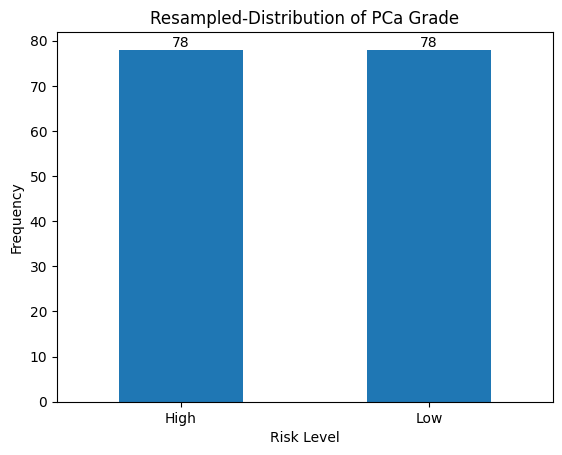




 MoAA Population


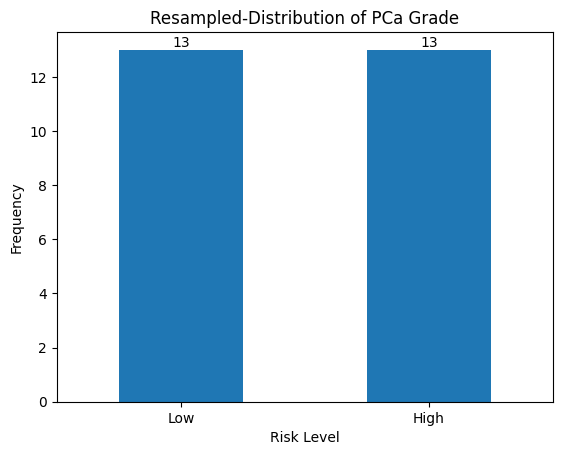




General Population


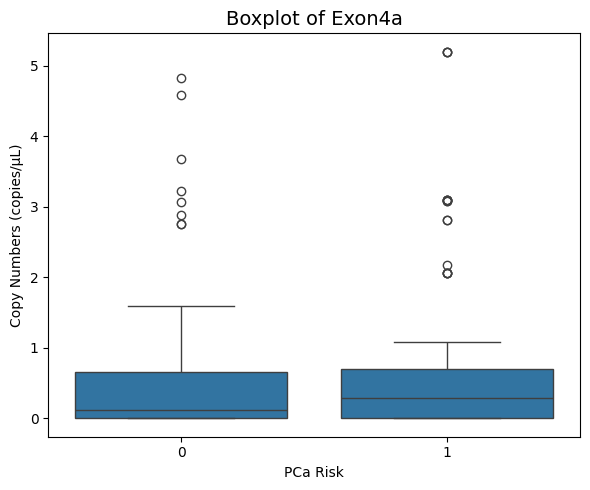

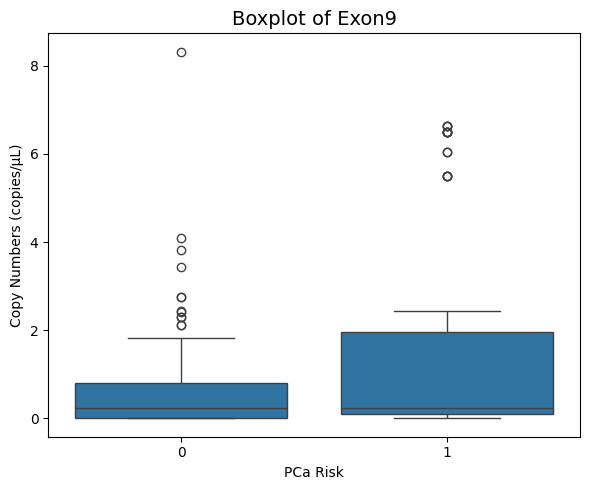

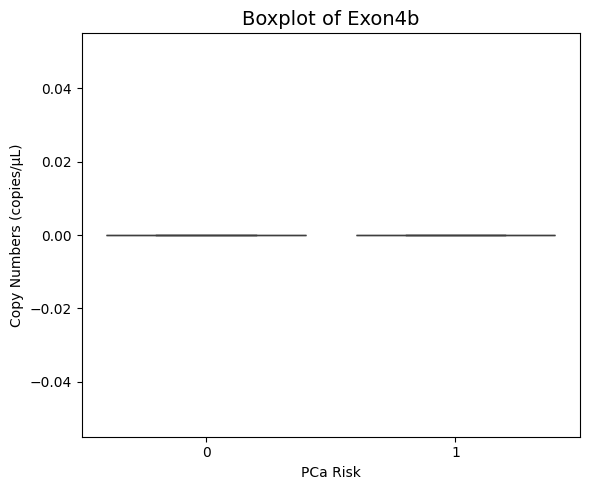

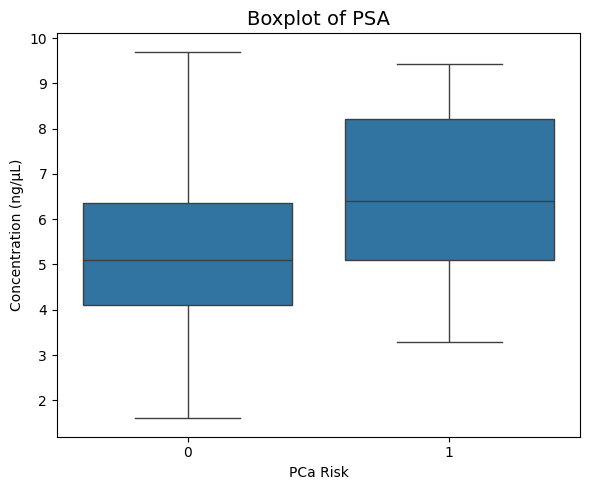




 MoAA Population


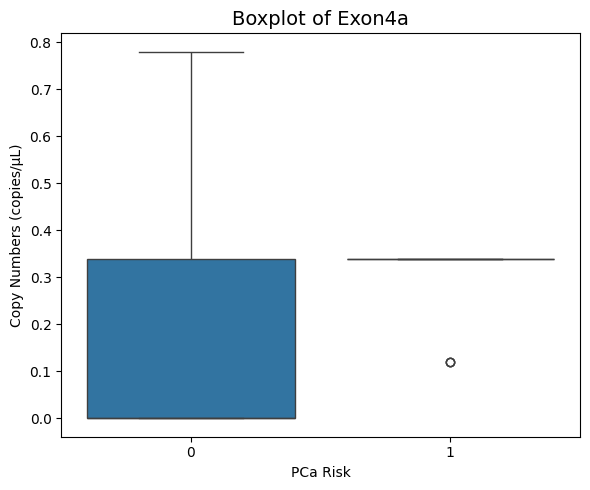

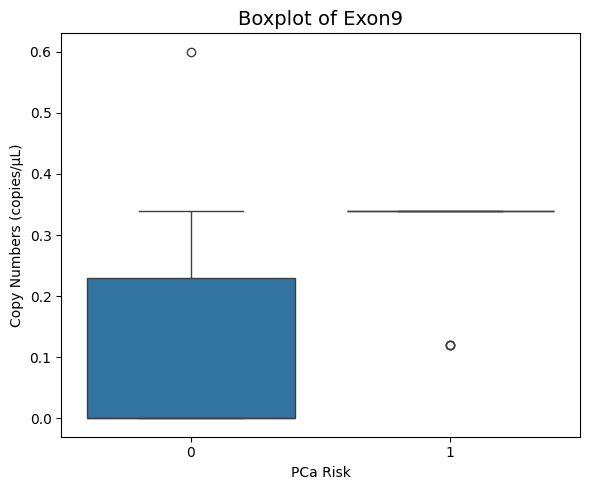

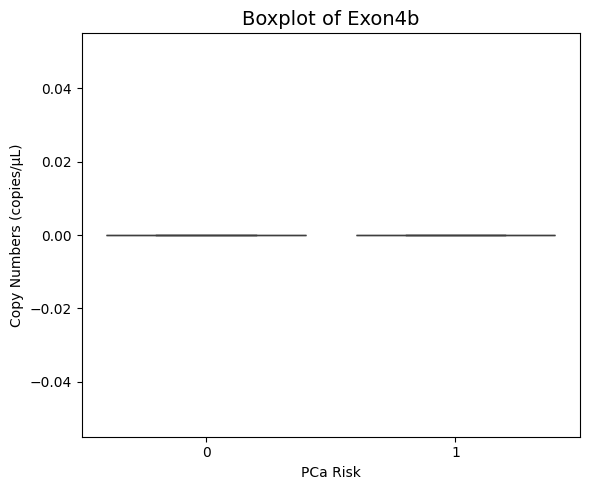

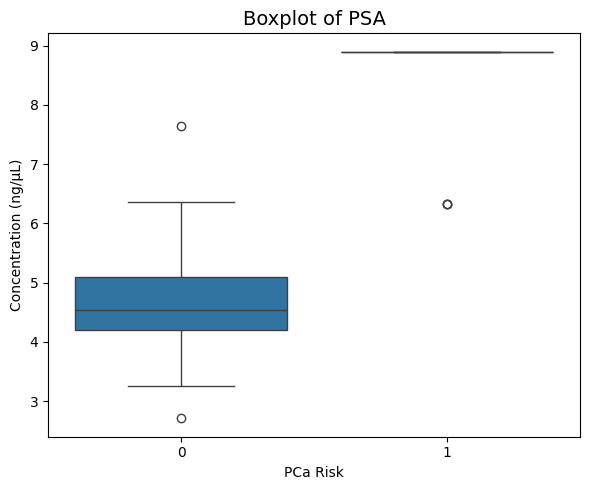

In [ ]:
# Function to resample data
def resample_data(data):
    # Extract feature set and target variable
    X = data.drop(columns=['GleasonRiskBinary'])
    y = data['GleasonRiskBinary']
    
    # Combine features and target into one dataset for resampling
    full_data = pd.concat([X, y], axis=1)

    # Separate majority and minority classes
    majority_class = full_data[full_data['GleasonRiskBinary'] == 0]
    minority_class = full_data[full_data['GleasonRiskBinary'] == 1]

    # Oversample the minority class with replacement to match the majority class size
    minority_class_upsampled = resample(
        minority_class, 
        replace=True, 
        n_samples=len(majority_class),  # Match the majority class size
        random_state=42
    )

    # Combine majority class with upsampled minority class
    balanced_data = pd.concat([majority_class, minority_class_upsampled])

    # Shuffle the data for randomness
    balanced_data = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)

    return balanced_data

# Resample the datasets
data_balanced = resample_data(data)
dataMoAA_balanced = resample_data(dataMoAA)


# Plot distributions for both datasets
print("\n\n\nGeneral Population")
plot_risk_distribution(data_balanced, 'Resampled-Distribution of PCa Grade')

print("\n\n\n MoAA Population")
plot_risk_distribution(dataMoAA_balanced, 'Resampled-Distribution of PCa Grade')


# Plot boxplots of re-sampled data
'''print("\n\n\nGeneral Population")
plot_boxplots(data_balanced)
plot_baseline_psa_boxplot(data_balanced)

print("\n\n\n MoAA Population")
plot_boxplots(dataMoAA_balanced)
plot_baseline_psa_boxplot(dataMoAA_balanced)'''


In [77]:
# Perform t-tests for both datasets
print("\nGeneral Population")
perform_t_tests(data_balanced, 'General Population')

print("\n\nMoAA Population")
perform_t_tests(dataMoAA_balanced, 'MoAA Population')




General Population

Model: PSA (Dataset: General Population)
T-statistic: -5.102
P-value: 0.000
Reject the null hypothesis: significant difference between groups.

Model: Exon4a (Dataset: General Population)
T-statistic: -1.065
P-value: 0.289
Fail to reject the null hypothesis: no significant difference between groups.

Model: Exon9 (Dataset: General Population)
T-statistic: -2.592
P-value: 0.011
Reject the null hypothesis: significant difference between groups.

Model: PSA, Exon4a (Dataset: General Population)
T-statistic: -5.083
P-value: 0.000
Reject the null hypothesis: significant difference between groups.

Model: PSA, Exon9 (Dataset: General Population)
T-statistic: -5.770
P-value: 0.000
Reject the null hypothesis: significant difference between groups.

Model: PSA, Exon4a, Exon9 (Dataset: General Population)
T-statistic: -4.930
P-value: 0.000
Reject the null hypothesis: significant difference between groups.


MoAA Population

Model: PSA (Dataset: MoAA Population)
T-statistic: 

In [78]:
# Perform likelihood ratio tests for both datasets
print("\nGeneral Population")
perform_likelihood_ratio_tests(data_balanced, 'General Population')

print("\n\n\nMoAA Population")
perform_likelihood_ratio_tests(dataMoAA_balanced, 'MoAA Population')



General Population

Testing model: ['PSA', 'Exon4a', 'Exon9'] vs ['PSA', 'Exon4a'] (Dataset: General Population)
Likelihood Ratio Statistic: 6.7565
P-value: 0.0093

Testing model: ['PSA', 'Exon4a', 'Exon9'] vs ['PSA', 'Exon9'] (Dataset: General Population)
Likelihood Ratio Statistic: 0.0345
P-value: 0.8527

Testing model: ['PSA', 'Exon4a', 'Exon9'] vs ['PSA'] (Dataset: General Population)
Likelihood Ratio Statistic: 9.1980
P-value: 0.0024

Testing model: ['PSA', 'Exon4a'] vs ['PSA'] (Dataset: General Population)
Likelihood Ratio Statistic: 2.4415
P-value: 0.1182

Testing model: ['PSA', 'Exon9'] vs ['PSA'] (Dataset: General Population)
Likelihood Ratio Statistic: 9.1635
P-value: 0.0025



MoAA Population

Testing model: ['PSA', 'Exon4a', 'Exon9'] vs ['PSA', 'Exon4a'] (Dataset: MoAA Population)
Likelihood Ratio Statistic: 0.3760
P-value: 0.5397

Testing model: ['PSA', 'Exon4a', 'Exon9'] vs ['PSA', 'Exon9'] (Dataset: MoAA Population)
Likelihood Ratio Statistic: 0.0328
P-value: 0.8564

Te

In [79]:
# Evaluate models for both datasets with specified train sizes
print("\nGeneral Population")
evaluate_models_mlr(data_balanced, 'General Population', train_size=0.6)

print("\n\n\nMoAA Population")
evaluate_models_mlr(dataMoAA_balanced, 'MoAA Population', train_size=0.6)



General Population

Metrics for model: ['PSA'] (Dataset: General Population)

Test Set Metrics:
Best Threshold: 0.60
Accuracy: 0.730
Recall (Sensitivity): 0.519
Specificity: 0.889
Positive Predictive Value (PPV): 0.778
Negative Predictive Value (NPV): 0.711

Metrics for model: ['Exon4a'] (Dataset: General Population)

Test Set Metrics:
Best Threshold: 0.60
Accuracy: 0.571
Recall (Sensitivity): 0.037
Specificity: 0.972
Positive Predictive Value (PPV): 0.500
Negative Predictive Value (NPV): 0.574

Metrics for model: ['Exon9'] (Dataset: General Population)

Test Set Metrics:
Best Threshold: 0.60
Accuracy: 0.651
Recall (Sensitivity): 0.185
Specificity: 1.000
Positive Predictive Value (PPV): 1.000
Negative Predictive Value (NPV): 0.621

Metrics for model: ['PSA', 'Exon4a'] (Dataset: General Population)

Test Set Metrics:
Best Threshold: 0.50
Accuracy: 0.730
Recall (Sensitivity): 0.815
Specificity: 0.667
Positive Predictive Value (PPV): 0.647
Negative Predictive Value (NPV): 0.828

Metrics 

General Population

Metrics for feature set: ['PSA'] (Dataset: General Population)

Metrics for feature set: ['Exon4a'] (Dataset: General Population)

Metrics for feature set: ['Exon9'] (Dataset: General Population)

Metrics for feature set: ['PSA', 'Exon4a'] (Dataset: General Population)

Metrics for feature set: ['PSA', 'Exon9'] (Dataset: General Population)

Metrics for feature set: ['PSA', 'Exon4a', 'Exon9'] (Dataset: General Population)


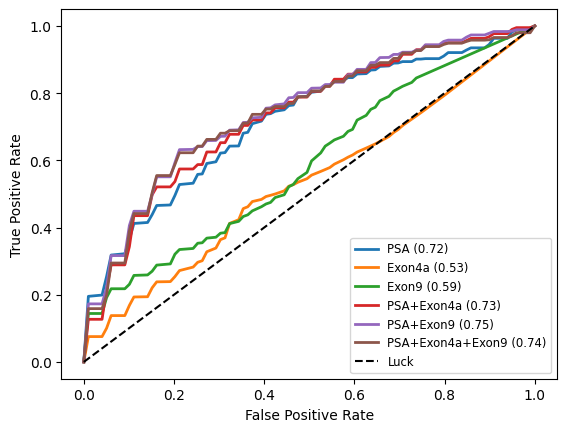




MoAA Population

Metrics for feature set: ['PSA'] (Dataset: MoAA Population)

Metrics for feature set: ['Exon4a'] (Dataset: MoAA Population)

Metrics for feature set: ['Exon9'] (Dataset: MoAA Population)

Metrics for feature set: ['PSA', 'Exon4a'] (Dataset: MoAA Population)

Metrics for feature set: ['PSA', 'Exon9'] (Dataset: MoAA Population)

Metrics for feature set: ['PSA', 'Exon4a', 'Exon9'] (Dataset: MoAA Population)


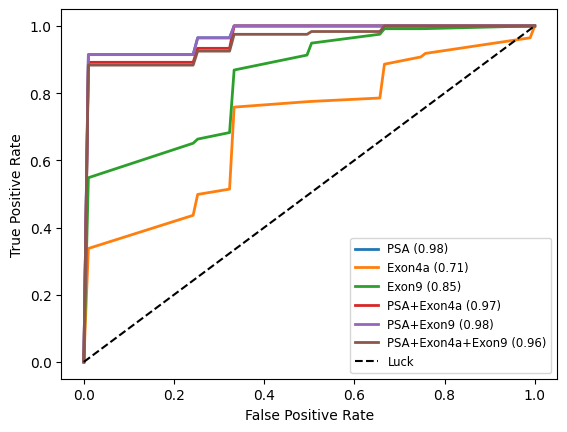

In [80]:
# Evaluate models for both datasets
print("General Population")
evaluate_cross_validation(data_balanced, 'General Population', nsplits= 4)

print("\n\n\nMoAA Population")
evaluate_cross_validation(dataMoAA_balanced, 'MoAA Population', nsplits= 4)

## Support Vector Machines

### Train-Test Split 

In [81]:
# Function to evaluate models
def evaluate_models_svm(data, dataset_name, train_size):
    for model in models:
        print(f"\nMetrics for model: {model} (Dataset: {dataset_name})")
        
        X = data[model]
        y = data['GleasonRiskBinary']

        # Split data with specified train size
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, random_state=66)

        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('svm', SVC(probability=False))  # Set probability=False
        ])

        # Fit model
        pipeline.fit(X_train, y_train)

        # Get predicted classes directly
        y_pred_final = pipeline.predict(X_test)  # Directly predict classes

        # Calculate final metrics using the predictions
        accuracy_test = metrics.accuracy_score(y_test, y_pred_final)
        recall_test = metrics.recall_score(y_test, y_pred_final)
        conf_matrix_test = confusion_matrix(y_test, y_pred_final)

        # Initialize NPV and PPV
        ppv = np.nan  # Positive Predictive Value
        npv = np.nan  # Negative Predictive Value

        # Check the shape of the final confusion matrix before unpacking
        if conf_matrix_test.shape == (2, 2):
            tn_test, fp_test, fn_test, tp_test = conf_matrix_test.ravel()
            specificity_test = tn_test / (tn_test + fp_test)

            # Calculate PPV and NPV
            ppv = tp_test / (tp_test + fp_test) if (tp_test + fp_test) > 0 else 0
            npv = tn_test / (tn_test + fn_test) if (tn_test + fn_test) > 0 else 0

            # Print metrics for test set
            print("\nTest Set Metrics:")
            print(f"Accuracy: {accuracy_test:.3f}")
            print(f"Recall (Sensitivity): {recall_test:.3f}")
            print(f"Specificity: {specificity_test:.3f}")
            print(f"Positive Predictive Value (PPV): {ppv:.3f}")
            print(f"Negative Predictive Value (NPV): {npv:.3f}")
        else:
            print("\nTest Set Metrics:")
            print(f"Accuracy: {accuracy_test:.3f}")
            print(f"Recall (Sensitivity): {recall_test:.3f}")
            print("Specificity: Not applicable (only one class present in predictions)")
            print("Positive Predictive Value (PPV): Not applicable")
            print("Negative Predictive Value (NPV): Not applicable")

# Evaluate models for both datasets with specified train sizes
print("General Population")
evaluate_models_svm(data, 'General Population', train_size=0.6)

print("\n\n\nMoAA Population")
evaluate_models_svm(dataMoAA, 'MoAA Population', train_size=0.6)

General Population

Metrics for model: ['PSA'] (Dataset: General Population)

Test Set Metrics:
Accuracy: 0.705
Recall (Sensitivity): 0.077
Specificity: 0.968
Positive Predictive Value (PPV): 0.500
Negative Predictive Value (NPV): 0.714

Metrics for model: ['Exon4a'] (Dataset: General Population)

Test Set Metrics:
Accuracy: 0.705
Recall (Sensitivity): 0.000
Specificity: 1.000
Positive Predictive Value (PPV): 0.000
Negative Predictive Value (NPV): 0.705

Metrics for model: ['Exon9'] (Dataset: General Population)

Test Set Metrics:
Accuracy: 0.750
Recall (Sensitivity): 0.154
Specificity: 1.000
Positive Predictive Value (PPV): 1.000
Negative Predictive Value (NPV): 0.738

Metrics for model: ['PSA', 'Exon4a'] (Dataset: General Population)

Test Set Metrics:
Accuracy: 0.705
Recall (Sensitivity): 0.077
Specificity: 0.968
Positive Predictive Value (PPV): 0.500
Negative Predictive Value (NPV): 0.714

Metrics for model: ['PSA', 'Exon9'] (Dataset: General Population)

Test Set Metrics:
Accuracy

### Resampled - Balanced Data

### Bootstrapping 

In [82]:
# Evaluate models for both datasets with specified train sizes
print("General Population")
evaluate_models_svm(data_balanced, 'General Population', train_size=0.6)

print("\n\n\nMoAA Population")
evaluate_models_svm(dataMoAA_balanced, 'MoAA Population', train_size=0.6)


General Population

Metrics for model: ['PSA'] (Dataset: General Population)

Test Set Metrics:
Accuracy: 0.651
Recall (Sensitivity): 0.889
Specificity: 0.472
Positive Predictive Value (PPV): 0.558
Negative Predictive Value (NPV): 0.850

Metrics for model: ['Exon4a'] (Dataset: General Population)

Test Set Metrics:
Accuracy: 0.429
Recall (Sensitivity): 1.000
Specificity: 0.000
Positive Predictive Value (PPV): 0.429
Negative Predictive Value (NPV): 0.000

Metrics for model: ['Exon9'] (Dataset: General Population)

Test Set Metrics:
Accuracy: 0.429
Recall (Sensitivity): 0.963
Specificity: 0.028
Positive Predictive Value (PPV): 0.426
Negative Predictive Value (NPV): 0.500

Metrics for model: ['PSA', 'Exon4a'] (Dataset: General Population)

Test Set Metrics:
Accuracy: 0.635
Recall (Sensitivity): 0.926
Specificity: 0.417
Positive Predictive Value (PPV): 0.543
Negative Predictive Value (NPV): 0.882

Metrics for model: ['PSA', 'Exon9'] (Dataset: General Population)

Test Set Metrics:
Accuracy

## Relevance Vector Machines

In [ ]:
# Function to evaluate models
def evaluate_models_rvm(data, dataset_name, train_size):
    for model in models:
        print(f"\nMetrics for model: {model} (Dataset: {dataset_name})")
        
        X = data[model]
        y = data['GleasonRiskBinary']

        # Split data with specified train size
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, random_state=66)
        #print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('rvm', RVC())  
        ])

        # Fit model
        pipeline.fit(X_train, y_train)

        # Get predicted classes directly
        y_pred_final = pipeline.predict(X_test)  # Directly predict classes

        # Calculate final metrics using the predictions
        accuracy_test = metrics.accuracy_score(y_test, y_pred_final)
        recall_test = metrics.recall_score(y_test, y_pred_final)
        conf_matrix_test = confusion_matrix(y_test, y_pred_final)

        # Initialize NPV and PPV
        ppv = np.nan  # Positive Predictive Value
        npv = np.nan  # Negative Predictive Value

        # Check the shape of the final confusion matrix before unpacking
        if conf_matrix_test.shape == (2, 2):
            tn_test, fp_test, fn_test, tp_test = conf_matrix_test.ravel()
            specificity_test = tn_test / (tn_test + fp_test)

            # Calculate PPV and NPV
            ppv = tp_test / (tp_test + fp_test) if (tp_test + fp_test) > 0 else 0
            npv = tn_test / (tn_test + fn_test) if (tn_test + fn_test) > 0 else 0

            # Print metrics for test set
            print("\nTest Set Metrics:")
            print(f"Accuracy: {accuracy_test:.3f}")
            print(f"Recall (Sensitivity): {recall_test:.3f}")
            print(f"Specificity: {specificity_test:.3f}")
            print(f"Positive Predictive Value (PPV): {ppv:.3f}")
            print(f"Negative Predictive Value (NPV): {npv:.3f}")
        else:
            print("\nTest Set Metrics:")
            print(f"Accuracy: {accuracy_test:.3f}")
            print(f"Recall (Sensitivity): {recall_test:.3f}")
            print("Specificity: Not applicable (only one class present in predictions)")
            print("Positive Predictive Value (PPV): Not applicable")
            print("Negative Predictive Value (NPV): Not applicable")

# Evaluate models for both datasets with specified train sizes
print("General Population")
evaluate_models_rvm(data, 'General Population', train_size=0.6)

print("\n\n\nMoAA Population")
evaluate_models_rvm(dataMoAA, 'MoAA Population', train_size=0.5)

General Population

Metrics for model: ['PSA'] (Dataset: General Population)
(64, 1) (44, 1) (64,) (44,)

Test Set Metrics:
Accuracy: 0.705
Recall (Sensitivity): 0.000
Specificity: 1.000
Positive Predictive Value (PPV): 0.000
Negative Predictive Value (NPV): 0.705

Metrics for model: ['Exon4a'] (Dataset: General Population)
(64, 1) (44, 1) (64,) (44,)

Test Set Metrics:
Accuracy: 0.705
Recall (Sensitivity): 0.000
Specificity: 1.000
Positive Predictive Value (PPV): 0.000
Negative Predictive Value (NPV): 0.705

Metrics for model: ['Exon9'] (Dataset: General Population)
(64, 1) (44, 1) (64,) (44,)

Test Set Metrics:
Accuracy: 0.750
Recall (Sensitivity): 0.154
Specificity: 1.000
Positive Predictive Value (PPV): 1.000
Negative Predictive Value (NPV): 0.738

Metrics for model: ['PSA', 'Exon4a'] (Dataset: General Population)
(64, 2) (44, 2) (64,) (44,)

Test Set Metrics:
Accuracy: 0.705
Recall (Sensitivity): 0.000
Specificity: 1.000
Positive Predictive Value (PPV): 0.000
Negative Predictive V

### Resampled - Balanced Data

### Bootstrapping 

In [84]:
# Evaluate models for both datasets with specified train sizes
print("General Population")
evaluate_models_rvm(data_balanced, 'General Population', train_size=0.65)

print("\n\n\nMoAA Population")
evaluate_models_rvm(dataMoAA_balanced, 'MoAA Population', train_size=0.6)


General Population

Metrics for model: ['PSA'] (Dataset: General Population)
(101, 1) (55, 1) (101,) (55,)

Test Set Metrics:
Accuracy: 0.709
Recall (Sensitivity): 0.640
Specificity: 0.767
Positive Predictive Value (PPV): 0.696
Negative Predictive Value (NPV): 0.719

Metrics for model: ['Exon4a'] (Dataset: General Population)
(101, 1) (55, 1) (101,) (55,)

Test Set Metrics:
Accuracy: 0.455
Recall (Sensitivity): 1.000
Specificity: 0.000
Positive Predictive Value (PPV): 0.455
Negative Predictive Value (NPV): 0.000

Metrics for model: ['Exon9'] (Dataset: General Population)
(101, 1) (55, 1) (101,) (55,)

Test Set Metrics:
Accuracy: 0.564
Recall (Sensitivity): 0.760
Specificity: 0.400
Positive Predictive Value (PPV): 0.514
Negative Predictive Value (NPV): 0.667

Metrics for model: ['PSA', 'Exon4a'] (Dataset: General Population)
(101, 2) (55, 2) (101,) (55,)

Test Set Metrics:
Accuracy: 0.745
Recall (Sensitivity): 0.760
Specificity: 0.733
Positive Predictive Value (PPV): 0.704
Negative Pred

# Prostate cancer Prediction 
# Status as the Response Variable

## Data Cleaning

In [85]:
# Convert Statuscode to categorical
data['Statuscode'] = data['Statuscode'].astype('category')

# Convert Statuscode to numeric
data['Statuscode'] = pd.to_numeric(data['Statuscode'], errors='coerce')

# Check for NaN values
print(data['Statuscode'].isnull().sum())  # Handle NaNs if any

# Drop NaN rows if necessary
data = data.dropna(subset=['Statuscode'])


0


In [86]:
# Convert Statuscode to categorical
dataMoAA['Statuscode'] = dataMoAA['Statuscode'].astype('category')

# Convert Statuscode to numeric
dataMoAA['Statuscode'] = pd.to_numeric(dataMoAA['Statuscode'], errors='coerce')

# Check for NaN values
print(dataMoAA['Statuscode'].isnull().sum())  # Handle NaNs if any

# Drop NaN rows if necessary
dataMoAA = dataMoAA.dropna(subset=['Statuscode'])


0


## Data Visualization: Distribution

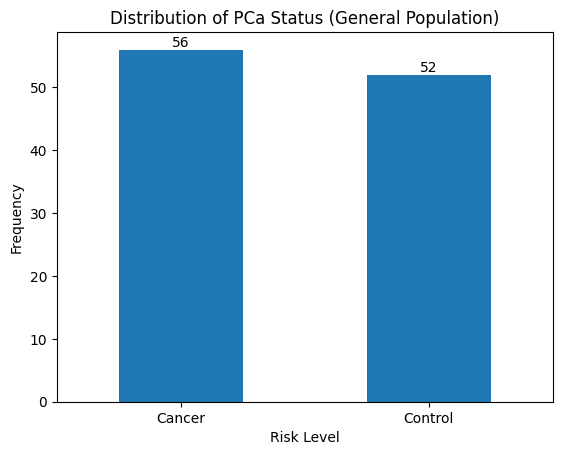

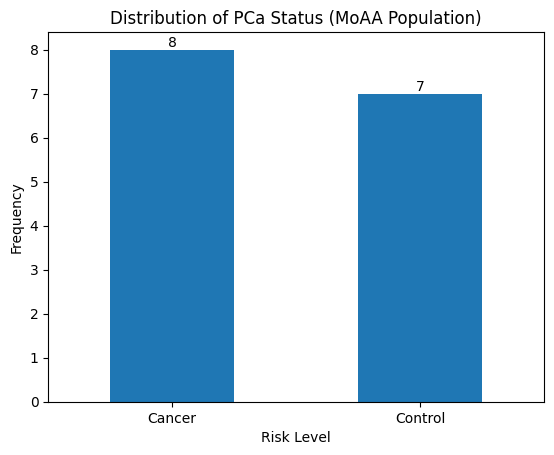

In [87]:
# Function to plot the distribution of PCa Status
def plot_pca_status_distribution(dataset, title):
    # Count the occurrences of each category
    counts = dataset['Status'].value_counts()

    # Plot the bar graph
    counts.plot(kind='bar')
    plt.title(title)
    plt.xlabel('Risk Level')
    plt.ylabel('Frequency')
    plt.xticks(rotation=0)  # Keep labels horizontal for better readability

    # Add numbers on top of the bars
    for index, value in enumerate(counts):
        plt.text(index, value, str(value), ha='center', va='bottom', fontsize=10)

    plt.show()

# Plot for both datasets
plot_pca_status_distribution(data, 'Distribution of PCa Status (General Population)')
plot_pca_status_distribution(dataMoAA, 'Distribution of PCa Status (MoAA Population)')

## Data Visualization: Boxplots


General Population


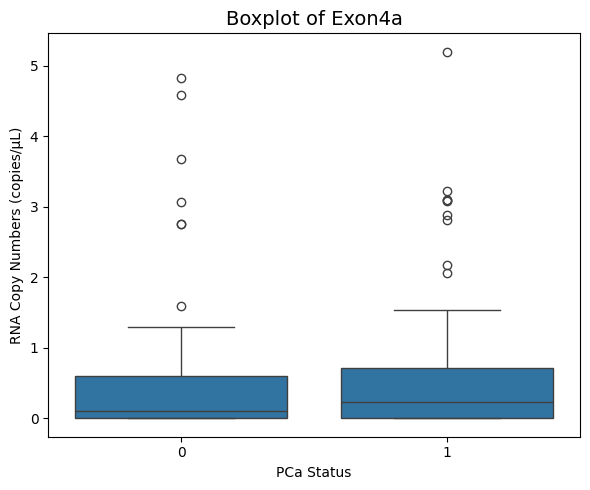

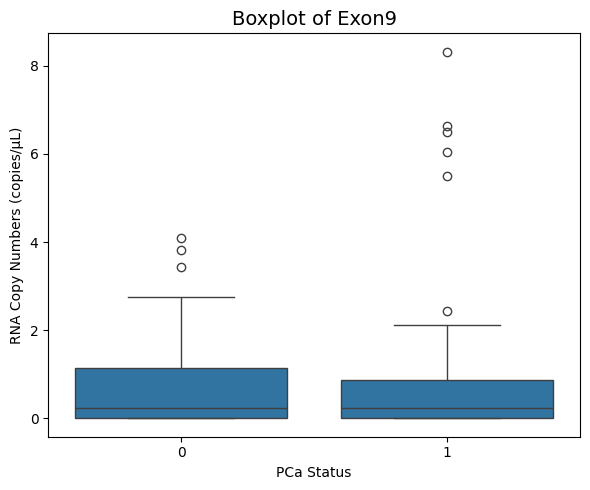

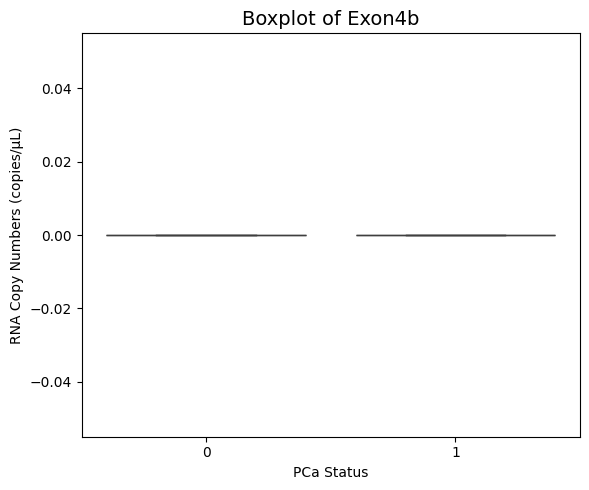



MoAA Population


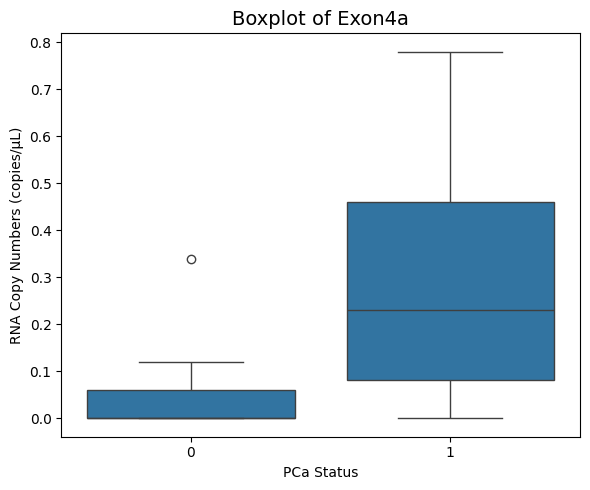

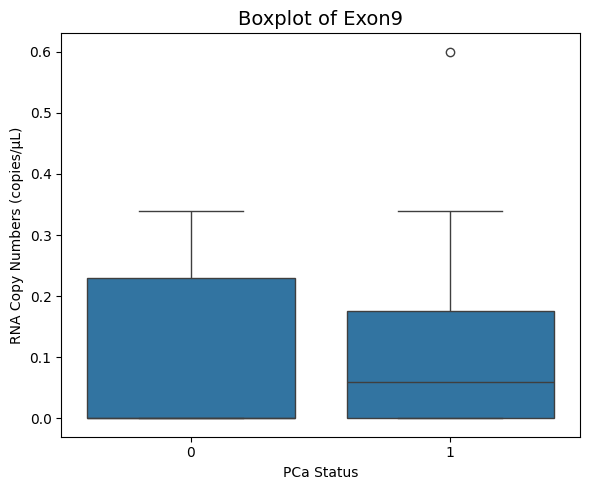

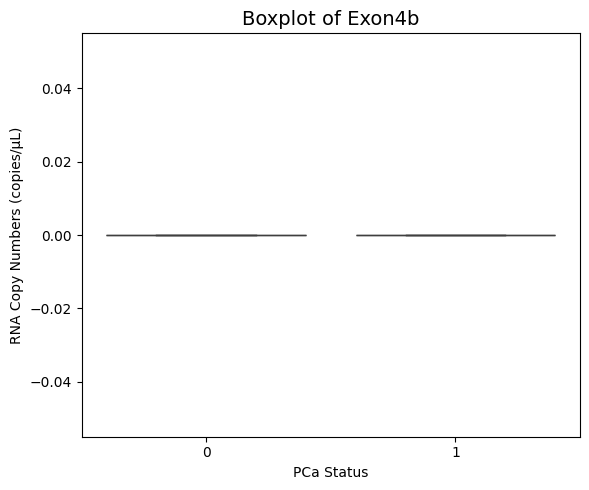

In [88]:
# Define the features
features = ['Exon4a', 'Exon9', 'Exon4b']

# Function to create boxplots for the specified features
def plot_boxplots(dataset, features):
    for feature in features:
        plt.figure(figsize=(6, 5))
        
        # Plot boxplot for the current feature
        sns.boxplot(x='Statuscode', y=feature, data=dataset)
        
        # Customize the title and axis labels
        plt.title(f"Boxplot of {feature}", fontsize=14)
        plt.xlabel("PCa Status")
        plt.ylabel('RNA Copy Numbers (copies/µL)')
        
        # Display the plot
        plt.tight_layout()
        plt.show()

# Plot for both datasets
print("General Population")
plot_boxplots(data, features)

print("\n\nMoAA Population")
plot_boxplots(dataMoAA, features)


General Population


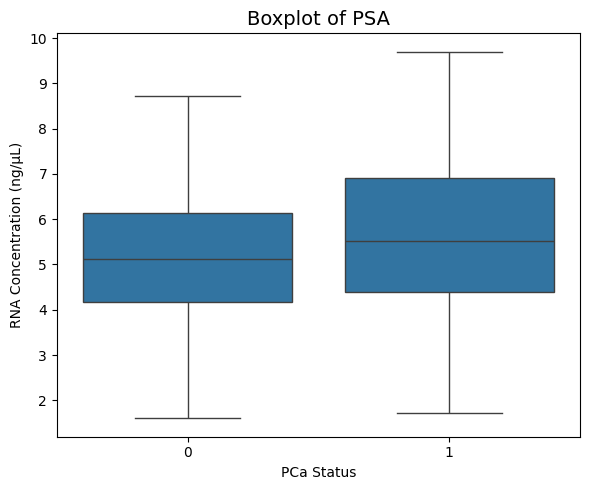



MoAA Population


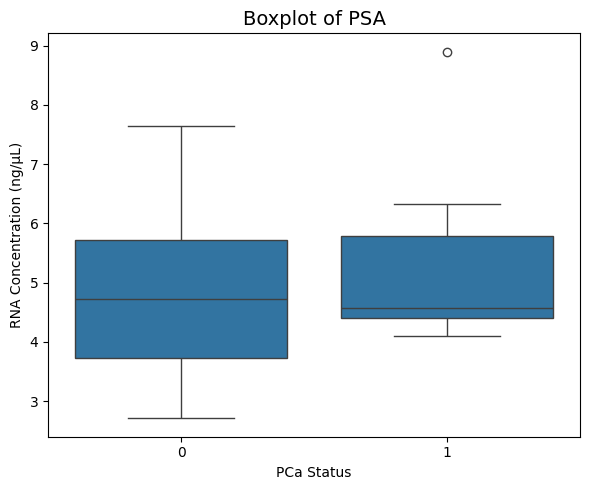

In [89]:
# Function to create a boxplot for baselinePSA
def plot_baselinePSA_boxplot(dataset):
    plt.figure(figsize=(6, 5))
    
    # Plot boxplot for baselinePSA
    sns.boxplot(x='Statuscode', y='PSA', data=dataset)
    
    # Customize the title and axis labels
    plt.title("Boxplot of PSA", fontsize=14)
    plt.xlabel("PCa Status")
    plt.ylabel('RNA Concentration (ng/µL)')
    
    # Display the plot
    plt.tight_layout()
    plt.show()

# Plot for both datasets
print("General Population")
plot_baselinePSA_boxplot(data)

print("\n\nMoAA Population")
plot_baselinePSA_boxplot(dataMoAA)

## Significance Test (T-test)

In [90]:
# Define models
models = [
    ['PSA'],
    ['Exon4a'],            
    ['Exon9'],
    ['PSA', 'Exon4a'],            
    ['PSA', 'Exon9'], 
    ['PSA', 'Exon4a', 'Exon9']            
]

# Function to perform t-tests for a dataset
def perform_t_tests(data, dataset_name):
    for model in models:
        print(f"\nModel: {', '.join(model)} (Dataset: {dataset_name})")
        
        X = data[model]
        y = data['Statuscode']

        # Split data into two groups based on the binary outcome
        group1 = X[y == 0].mean(axis=1)  # Group where GleasonRiskBinary is 0
        group2 = X[y == 1].mean(axis=1)  # Group where GleasonRiskBinary is 1

        # Perform t-test
        t_stat, p_value = stats.ttest_ind(group1, group2, equal_var=False)  # Welch's t-test

        # Print results
        print(f"T-statistic: {t_stat:.3f}")
        print(f"P-value: {p_value:.3f}")

        # Interpret the p-value
        alpha = 0.05
        if p_value < alpha:
            print("Reject the null hypothesis: significant difference between groups.")
        else:
            print("Fail to reject the null hypothesis: no significant difference between groups.")

# Perform t-tests for both datasets
print("General Population")
perform_t_tests(data, 'General Population')

print("\n\nMoAA Population")
perform_t_tests(dataMoAA, 'MoAA Population')

General Population

Model: PSA (Dataset: General Population)
T-statistic: -2.085
P-value: 0.039
Reject the null hypothesis: significant difference between groups.

Model: Exon4a (Dataset: General Population)
T-statistic: -0.453
P-value: 0.651
Fail to reject the null hypothesis: no significant difference between groups.

Model: Exon9 (Dataset: General Population)
T-statistic: -0.774
P-value: 0.441
Fail to reject the null hypothesis: no significant difference between groups.

Model: PSA, Exon4a (Dataset: General Population)
T-statistic: -1.962
P-value: 0.052
Fail to reject the null hypothesis: no significant difference between groups.

Model: PSA, Exon9 (Dataset: General Population)
T-statistic: -2.090
P-value: 0.039
Reject the null hypothesis: significant difference between groups.

Model: PSA, Exon4a, Exon9 (Dataset: General Population)
T-statistic: -1.782
P-value: 0.078
Fail to reject the null hypothesis: no significant difference between groups.


MoAA Population

Model: PSA (Dataset

## Likelihood Ratio Test

In [91]:

# Custom function for chi-square probability
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

# Define function to perform likelihood ratio test
def likelihood_ratio_test(llmin, llmax):
    lr_stat = 2 * (llmax - llmin)
    p_value = stats.chisqprob(lr_stat, 1)  # llmax has 1 dof more than llmin
    return lr_stat, p_value  # Results of likelihood ratio test

# Define model pairs for comparison
model_pairs = [
    (['PSA', 'Exon4a', 'Exon9'], ['PSA', 'Exon4a']),
    (['PSA', 'Exon4a', 'Exon9'], ['PSA', 'Exon9']),
    (['PSA', 'Exon4a', 'Exon9'], ['PSA']),
    (['PSA', 'Exon4a'], ['PSA']),
    (['PSA', 'Exon9'], ['PSA'])
]


# Function to perform likelihood ratio tests for a given dataset
def perform_likelihood_ratio_tests(data, dataset_name):
    y = data['Statuscode']
    
    # Loop through each model pair
    for full_features, reduced_features in model_pairs:
        print(f"\nTesting model: {full_features} vs {reduced_features} (Dataset: {dataset_name})")

        # Fit the full model
        X_full = data[full_features]
        X_full = sm.add_constant(X_full)  # Adding intercept
        full_model = sm.Logit(y, X_full).fit(disp=0)  # disp=0 to suppress output

        # Fit the reduced model
        X_reduced = data[reduced_features]
        X_reduced = sm.add_constant(X_reduced)  # Adding intercept
        reduced_model = sm.Logit(y, X_reduced).fit(disp=0)  # disp=0 to suppress output

        # Get log-likelihood values
        llmax = full_model.llf  # Log-likelihood of the full model
        llmin = reduced_model.llf  # Log-likelihood of the reduced model

        # Perform the likelihood ratio test
        lr_stat, p_value = likelihood_ratio_test(llmin, llmax)

        # Print results
        print(f"Likelihood Ratio Statistic: {lr_stat:.4f}")
        print(f"P-value: {p_value:.4f}")

# Perform likelihood ratio tests for both datasets
print("General Population")
perform_likelihood_ratio_tests(data, 'General Population')

print("\n\n\nMoAA Population")
perform_likelihood_ratio_tests(dataMoAA, 'MoAA Population')

General Population

Testing model: ['PSA', 'Exon4a', 'Exon9'] vs ['PSA', 'Exon4a'] (Dataset: General Population)
Likelihood Ratio Statistic: 0.4849
P-value: 0.4862

Testing model: ['PSA', 'Exon4a', 'Exon9'] vs ['PSA', 'Exon9'] (Dataset: General Population)
Likelihood Ratio Statistic: 0.0060
P-value: 0.9383

Testing model: ['PSA', 'Exon4a', 'Exon9'] vs ['PSA'] (Dataset: General Population)
Likelihood Ratio Statistic: 0.6759
P-value: 0.4110

Testing model: ['PSA', 'Exon4a'] vs ['PSA'] (Dataset: General Population)
Likelihood Ratio Statistic: 0.1909
P-value: 0.6622

Testing model: ['PSA', 'Exon9'] vs ['PSA'] (Dataset: General Population)
Likelihood Ratio Statistic: 0.6699
P-value: 0.4131



MoAA Population

Testing model: ['PSA', 'Exon4a', 'Exon9'] vs ['PSA', 'Exon4a'] (Dataset: MoAA Population)
Likelihood Ratio Statistic: 2.5790
P-value: 0.1083

Testing model: ['PSA', 'Exon4a', 'Exon9'] vs ['PSA', 'Exon9'] (Dataset: MoAA Population)
Likelihood Ratio Statistic: 6.5142
P-value: 0.0107

Tes

## Multiple Logistic Regression

### Train Test Split

### Youden's index threshold

In [92]:
# Function to evaluate models
def evaluate_models(data, dataset_name, train_size):
    for model in models:
        print(f"\nMetrics for model: {model} (Dataset: {dataset_name})")
        
        X = data[model]
        y = data['Statuscode']

        # Split data with specified train size
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, random_state=66)

        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('logistic_regression', LogisticRegression())
        ])

        # Fit model
        pipeline.fit(X_train, y_train)

        # Get predicted probabilities
        y_pred_proba = pipeline.predict_proba(X_test)[:, 1]  # Probabilities for test set

        # Define thresholds
        thresholds = np.arange(0.0, 1.0, 0.1)
        best_youden_index = -1
        best_threshold = 0.5

        for threshold in thresholds:
            # Convert probabilities to binary predictions
            y_pred = (y_pred_proba >= threshold).astype(int)

            # Calculate confusion matrix
            conf_matrix = confusion_matrix(y_test, y_pred)

            # Check if the confusion matrix is valid for binary classification
            if conf_matrix.shape == (2, 2):
                tn, fp, fn, tp = conf_matrix.ravel()

                # Calculate sensitivity and specificity
                sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
                specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

                # Calculate PPV and NPV
                ppv = tp / (tp + fp) if (tp + fp) > 0 else 0
                npv = tn / (tn + fn) if (tn + fn) > 0 else 0

                # Calculate Youden's Index
                youden_index = sensitivity + specificity - 1

                # Check if this is the best threshold
                if youden_index > best_youden_index:
                    best_youden_index = youden_index
                    best_threshold = threshold

        # Apply the best threshold for final predictions
        y_pred_final = (y_pred_proba >= best_threshold).astype(int)

        # Calculate final metrics using the best threshold
        accuracy_test = metrics.accuracy_score(y_test, y_pred_final)
        recall_test = metrics.recall_score(y_test, y_pred_final)
        conf_matrix_test = confusion_matrix(y_test, y_pred_final)

        # Check the shape of the final confusion matrix before unpacking
        if conf_matrix_test.shape == (2, 2):
            tn_test, fp_test, fn_test, tp_test = conf_matrix_test.ravel()
            specificity_test = tn_test / (tn_test + fp_test)

            # Calculate final PPV and NPV
            final_ppv = tp_test / (tp_test + fp_test) if (tp_test + fp_test) > 0 else 0
            final_npv = tn_test / (tn_test + fn_test) if (tn_test + fn_test) > 0 else 0
            
            # Print metrics for test set
            print("\nTest Set Metrics:")
            print(f"Best Threshold: {best_threshold:.2f}")
            print(f"Accuracy: {accuracy_test:.3f}")
            print(f"Recall (Sensitivity): {recall_test:.3f}")
            print(f"Specificity: {specificity_test:.3f}")
            print(f"Positive Predictive Value (PPV): {final_ppv:.3f}")
            print(f"Negative Predictive Value (NPV): {final_npv:.3f}")
        else:
            print("\nTest Set Metrics:")
            print(f"Best Threshold: {best_threshold:.2f}")
            print(f"Accuracy: {accuracy_test:.3f}")
            print(f"Recall (Sensitivity): {recall_test:.3f}")
            print("Specificity: Not applicable (only one class present in predictions)")
            print("Positive Predictive Value (PPV): Not applicable")
            print("Negative Predictive Value (NPV): Not applicable")

# Evaluate models for both datasets with specified train sizes
print("General Population")
evaluate_models(data, 'General Population', train_size=0.6)

print("\n\n\nMoAA Population")
evaluate_models(dataMoAA, 'MoAA Population', train_size=0.6)

General Population

Metrics for model: ['PSA'] (Dataset: General Population)

Test Set Metrics:
Best Threshold: 0.50
Accuracy: 0.591
Recall (Sensitivity): 0.773
Specificity: 0.409
Positive Predictive Value (PPV): 0.567
Negative Predictive Value (NPV): 0.643

Metrics for model: ['Exon4a'] (Dataset: General Population)

Test Set Metrics:
Best Threshold: 0.00
Accuracy: 0.500
Recall (Sensitivity): 1.000
Specificity: 0.000
Positive Predictive Value (PPV): 0.500
Negative Predictive Value (NPV): 0.000

Metrics for model: ['Exon9'] (Dataset: General Population)

Test Set Metrics:
Best Threshold: 0.60
Accuracy: 0.545
Recall (Sensitivity): 0.091
Specificity: 1.000
Positive Predictive Value (PPV): 1.000
Negative Predictive Value (NPV): 0.524

Metrics for model: ['PSA', 'Exon4a'] (Dataset: General Population)

Test Set Metrics:
Best Threshold: 0.50
Accuracy: 0.659
Recall (Sensitivity): 0.727
Specificity: 0.591
Positive Predictive Value (PPV): 0.640
Negative Predictive Value (NPV): 0.684

Metrics f

### K fold Cross Validation and ROC

General Population

Metrics for feature set: ['PSA'] (Dataset: General Population)

Metrics for feature set: ['Exon4a'] (Dataset: General Population)

Metrics for feature set: ['Exon9'] (Dataset: General Population)

Metrics for feature set: ['PSA', 'Exon4a'] (Dataset: General Population)

Metrics for feature set: ['PSA', 'Exon9'] (Dataset: General Population)

Metrics for feature set: ['PSA', 'Exon4a', 'Exon9'] (Dataset: General Population)


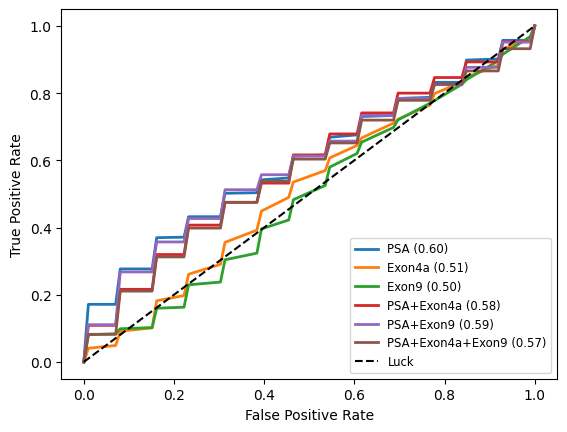




MoAA Population

Metrics for feature set: ['PSA'] (Dataset: MoAA Population)

Metrics for feature set: ['Exon4a'] (Dataset: MoAA Population)

Metrics for feature set: ['Exon9'] (Dataset: MoAA Population)

Metrics for feature set: ['PSA', 'Exon4a'] (Dataset: MoAA Population)

Metrics for feature set: ['PSA', 'Exon9'] (Dataset: MoAA Population)

Metrics for feature set: ['PSA', 'Exon4a', 'Exon9'] (Dataset: MoAA Population)


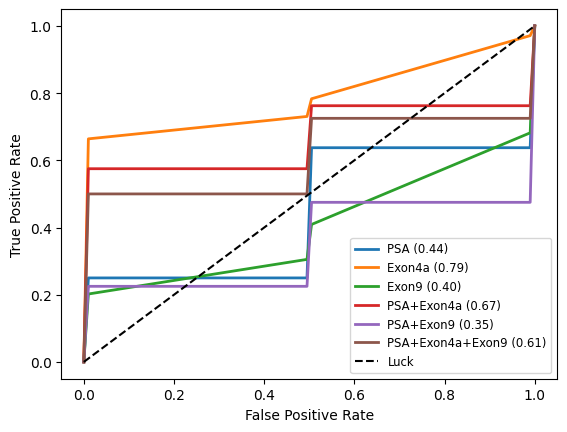

In [93]:
def evaluate_cross_validation(data, dataset_name, nsplits):
    # Loop through each model and perform 4-fold cross-validation with 10 repetitions
    nrepeats = 10
    score_list = []

    for model in models:
        print(f"\nMetrics for feature set: {model} (Dataset: {dataset_name})")
        
        X = data[model]
        y = data['Statuscode']
        
        # Convert Dataframe to Numpy array
        Xdata = X.to_numpy()
        ydata = y.to_numpy()
        
        # Initialize KFold
        cv = RepeatedStratifiedKFold(n_splits=nsplits, n_repeats=nrepeats, random_state=10)
        
        # Create Model
        lr = LogisticRegression(solver='liblinear',C=10,random_state = 1)
        
        # Evaluate Model
        scores = cross_val_score(lr,X,y,scoring = 'roc_auc',cv = cv, n_jobs=-1)
        
        # Mean and 95% CI for AUC
        auc_mean = np.mean(scores)
        #auc_ci = st.t.interval(alpha=0.95, df=len(scores)-1, loc=auc_mean, scale=st.sem(scores))
        score_list.append(auc_mean)
        
        # Plot mean ROC curve for different models
        mean_tpr = 0.0
        mean_fpr = np.linspace(0, 1, 100)
        all_tpr = []
        tprs = []
        
        for i, (train, test) in enumerate(cv.split(X,y)):
            lr.fit(Xdata[train],ydata[train])
            probas_ = lr.predict_proba(Xdata[test])
            
            # Compute ROC curve and area the curve
            fpr, tpr, thresholds = roc_curve(ydata[test], probas_[:, 1])
            interp_tpr = np.interp(mean_fpr,fpr,tpr)
            interp_tpr[0]=0.0
            tprs.append(interp_tpr)
            #mean_tpr += np.interp(mean_fpr, fpr, tpr)
            #mean_tpr[0] = 0.0
            #roc_auc = auc(fpr, tpr)
            #plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
        
        
        mean_tpr = np.mean(tprs,axis=0)
        mean_tpr[-1]=1.0
        #mean_tpr /= len(cv)
        if len(model)==1:
            plt.plot(mean_fpr, mean_tpr,
                label=model[0]+" "+'(%0.2f)' % auc_mean, lw=2)
        elif len(model)==2:
            plt.plot(mean_fpr, mean_tpr,
                label=model[0]+"+"+model[1]+" "+'(%0.2f)' % auc_mean, lw=2)
        else:
            plt.plot(mean_fpr, mean_tpr,
                label=model[0]+"+"+model[1]+"+"+ model[2]+" "+'(%0.2f)' % auc_mean, lw=2)

    plt.plot([0, 1], [0, 1], 'k--', label='Luck')    
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    #plt.title('ROC curves for different models')
    plt.legend(loc="lower right",fontsize='small')
    plt.show()   
    
# Evaluate models for both datasets
print("General Population")
evaluate_cross_validation(data, 'General Population', nsplits = 4)

print("\n\n\nMoAA Population")
evaluate_cross_validation(dataMoAA, 'MoAA Population', nsplits = 4)

## Support Vector Machines

### Train Test Split

In [94]:
# Function to evaluate models
def evaluate_models(data, dataset_name, train_size):
    for model in models:
        print(f"\nMetrics for model: {model} (Dataset: {dataset_name})")
        
        X = data[model]
        y = data['Statuscode']

        # Split data with specified train size
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, random_state=66)

        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('svm', SVC(probability=False))  # Set probability=False
        ])

        # Fit model
        pipeline.fit(X_train, y_train)

        # Get predicted classes directly
        y_pred_final = pipeline.predict(X_test)  # Directly predict classes

        # Calculate final metrics using the predictions
        accuracy_test = metrics.accuracy_score(y_test, y_pred_final)
        recall_test = metrics.recall_score(y_test, y_pred_final)
        conf_matrix_test = confusion_matrix(y_test, y_pred_final)

        # Initialize NPV and PPV
        ppv = np.nan  # Positive Predictive Value
        npv = np.nan  # Negative Predictive Value

        # Check the shape of the final confusion matrix before unpacking
        if conf_matrix_test.shape == (2, 2):
            tn_test, fp_test, fn_test, tp_test = conf_matrix_test.ravel()
            specificity_test = tn_test / (tn_test + fp_test)

            # Calculate PPV and NPV
            ppv = tp_test / (tp_test + fp_test) if (tp_test + fp_test) > 0 else 0
            npv = tn_test / (tn_test + fn_test) if (tn_test + fn_test) > 0 else 0

            # Print metrics for test set
            print("\nTest Set Metrics:")
            print(f"Accuracy: {accuracy_test:.3f}")
            print(f"Recall (Sensitivity): {recall_test:.3f}")
            print(f"Specificity: {specificity_test:.3f}")
            print(f"Positive Predictive Value (PPV): {ppv:.3f}")
            print(f"Negative Predictive Value (NPV): {npv:.3f}")
        else:
            print("\nTest Set Metrics:")
            print(f"Accuracy: {accuracy_test:.3f}")
            print(f"Recall (Sensitivity): {recall_test:.3f}")
            print("Specificity: Not applicable (only one class present in predictions)")
            print("Positive Predictive Value (PPV): Not applicable")
            print("Negative Predictive Value (NPV): Not applicable")

# Evaluate models for both datasets with specified train sizes
print("General Population")
evaluate_models(data, 'General Population', train_size=0.6)

print("\n\n\nMoAA Population")
evaluate_models(dataMoAA, 'MoAA Population', train_size=0.6)

General Population

Metrics for model: ['PSA'] (Dataset: General Population)

Test Set Metrics:
Accuracy: 0.523
Recall (Sensitivity): 0.636
Specificity: 0.409
Positive Predictive Value (PPV): 0.519
Negative Predictive Value (NPV): 0.529

Metrics for model: ['Exon4a'] (Dataset: General Population)

Test Set Metrics:
Accuracy: 0.500
Recall (Sensitivity): 1.000
Specificity: 0.000
Positive Predictive Value (PPV): 0.500
Negative Predictive Value (NPV): 0.000

Metrics for model: ['Exon9'] (Dataset: General Population)

Test Set Metrics:
Accuracy: 0.523
Recall (Sensitivity): 1.000
Specificity: 0.045
Positive Predictive Value (PPV): 0.512
Negative Predictive Value (NPV): 1.000

Metrics for model: ['PSA', 'Exon4a'] (Dataset: General Population)

Test Set Metrics:
Accuracy: 0.545
Recall (Sensitivity): 0.409
Specificity: 0.682
Positive Predictive Value (PPV): 0.562
Negative Predictive Value (NPV): 0.536

Metrics for model: ['PSA', 'Exon9'] (Dataset: General Population)

Test Set Metrics:
Accuracy

## Relevance Vector Machines

### Train Test Split

In [95]:
# Function to evaluate models
def evaluate_model_rvm(data, dataset_name, train_size):
    for model in models:
        print(f"\nMetrics for model: {model} (Dataset: {dataset_name})")
        
        X = data[model]
        y = data['Statuscode']

        # Split data with specified train size
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, random_state=66)

        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('rvm', RVC())  # Set probability=False
        ])

        # Fit model
        pipeline.fit(X_train, y_train)

        # Get predicted classes directly
        y_pred_final = pipeline.predict(X_test)  # Directly predict classes

        # Calculate final metrics using the predictions
        accuracy_test = metrics.accuracy_score(y_test, y_pred_final)
        recall_test = metrics.recall_score(y_test, y_pred_final)
        conf_matrix_test = confusion_matrix(y_test, y_pred_final)

        # Initialize NPV and PPV
        ppv = np.nan  # Positive Predictive Value
        npv = np.nan  # Negative Predictive Value

        # Check the shape of the final confusion matrix before unpacking
        if conf_matrix_test.shape == (2, 2):
            tn_test, fp_test, fn_test, tp_test = conf_matrix_test.ravel()
            specificity_test = tn_test / (tn_test + fp_test)

            # Calculate PPV and NPV
            ppv = tp_test / (tp_test + fp_test) if (tp_test + fp_test) > 0 else 0
            npv = tn_test / (tn_test + fn_test) if (tn_test + fn_test) > 0 else 0

            # Print metrics for test set
            print("\nTest Set Metrics:")
            print(f"Accuracy: {accuracy_test:.3f}")
            print(f"Recall (Sensitivity): {recall_test:.3f}")
            print(f"Specificity: {specificity_test:.3f}")
            print(f"Positive Predictive Value (PPV): {ppv:.3f}")
            print(f"Negative Predictive Value (NPV): {npv:.3f}")
        else:
            print("\nTest Set Metrics:")
            print(f"Accuracy: {accuracy_test:.3f}")
            print(f"Recall (Sensitivity): {recall_test:.3f}")
            print("Specificity: Not applicable (only one class present in predictions)")
            print("Positive Predictive Value (PPV): Not applicable")
            print("Negative Predictive Value (NPV): Not applicable")

# Evaluate models for both datasets with specified train sizes
print("General Population")
evaluate_model_rvm(data, 'General Population', train_size=0.6)

print("\n\n\nMoAA Population")
evaluate_model_rvm(dataMoAA, 'MoAA Population', train_size=0.6)

General Population

Metrics for model: ['PSA'] (Dataset: General Population)

Test Set Metrics:
Accuracy: 0.500
Recall (Sensitivity): 1.000
Specificity: 0.000
Positive Predictive Value (PPV): 0.500
Negative Predictive Value (NPV): 0.000

Metrics for model: ['Exon4a'] (Dataset: General Population)

Test Set Metrics:
Accuracy: 0.500
Recall (Sensitivity): 1.000
Specificity: 0.000
Positive Predictive Value (PPV): 0.500
Negative Predictive Value (NPV): 0.000

Metrics for model: ['Exon9'] (Dataset: General Population)

Test Set Metrics:
Accuracy: 0.545
Recall (Sensitivity): 1.000
Specificity: 0.091
Positive Predictive Value (PPV): 0.524
Negative Predictive Value (NPV): 1.000

Metrics for model: ['PSA', 'Exon4a'] (Dataset: General Population)

Test Set Metrics:
Accuracy: 0.500
Recall (Sensitivity): 1.000
Specificity: 0.000
Positive Predictive Value (PPV): 0.500
Negative Predictive Value (NPV): 0.000

Metrics for model: ['PSA', 'Exon9'] (Dataset: General Population)

Test Set Metrics:
Accuracy